#### 라이브러리 호출

In [2]:
import logging  # to further silence deprecation warnings
import warnings
from warnings import filterwarnings

# Standard library
import os

# Data handling
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning & clustering
from sklearn import metrics, preprocessing
from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV
import umap.umap_ as umap
from umap import validation
import hdbscan
from hdbscan.validity import validity_index

# Custom modules
from denseclus import DenseClus

# Suppress the specific FutureWarning from sklearn
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message=".*force_all_finite.*"
)

logging.captureWarnings(True)

In [3]:
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set(rc={"figure.figsize": (10, 8)})

#### 데이터 호출

In [12]:
SEED = 42
np.random.seed(SEED)  # set the random seed as best we can

data_path = './data/flat-training.csv'

df = pd.read_csv(data_path)

# 결측치가 하나라도 있는 열을 제거
df = df.dropna(axis=1)

# random sampling 진행
df = df.sample(n=20000, random_state=SEED)

df.head(5)

,dog,cat,deer,panda,koala,otter,hedgehog,squirrel,dolphin,penguin,...,blanket,button,whistle,marble,wagon,storybook,candle,clover,bubble,cookie
75721,72,0D45,2.70,0,T0,B9DE,28.2,0,1,20,...,A8,-5,8,0,-0.96,-73,B4,0.61,0,C16
80184,44,C09E,4.54,0,T2,B9DE,38.8,0,1,20,...,A6,28,14,0,-0.81,-86,B4,0.11,0,C16
19864,50,1520,3.12,-1,T1,B9DE,41.0,0,1,20,...,A4,-31,8,0,-0.64,32,B1,0.07,0,C8
76699,36,D668,4.37,0,T1,027A,41.0,1,1,20,...,A5,37,11,0,-0.94,-76,B2,0.07,0,C9
92991,31,A2FB,4.36,-2,T3,027A,39.0,0,1,20,...,A6,-25,2,0,-0.69,-66,B4,0.44,0,C18


In [13]:
df.dtypes

dog            int64
cat           object
deer         float64
panda          int64
koala         object
              ...   
storybook      int64
candle        object
clover       float64
bubble         int64
cookie        object
Length: 76, dtype: object

#### 하이퍼파라미터 튜닝

In [ ]:
from itertools import product

def evaluate_params(umap_params, hdbscan_params, data):
    clf = DenseClus(
        random_state=SEED,
        umap_combine_method='intersection_union_mapper',
        umap_params=umap_params,
        hdbscan_params=hdbscan_params)
    
    clf.fit(data)
    labels = clf.labels_
    coverage = (labels >= 0).mean()        # 군집에 속한 비율
    dbcv = clf.hdbscan_.relative_validity_ # HDBSCAN의 DBCV 지표

    return coverage, dbcv

# UMAP 하이퍼파라미터 후보
umap_param_grid = [
    {
        "categorical": {"n_neighbors": n_cat, "min_dist": m_cat},
        "numerical": {"n_neighbors": n_num, "min_dist": m_num},
        "combined":  {"n_neighbors": n_com, "min_dist": m_com},
    }
    for n_cat, m_cat, n_num, m_num, n_com, m_com in product(
        [15, 30],      # categorical n_neighbors 후보
        [0.0, 0.2],    # categorical min_dist 후보
        [20, 40],      # numerical n_neighbors 후보
        [0.0, 0.2],    # numerical min_dist 후보
        [5, 10],       # combined n_neighbors 후보
        [0.0, 0.2],    # combined min_dist 후보
    )
]


# HDBSCAN 하이퍼파라미터 후보
hdbscan_param_grid = [
    {"min_samples": ms, "min_cluster_size": mcs,
    "gen_min_span_tree": True,}
    for ms, mcs in product([10, 30, 50], [100, 200, 300])
]

In [ ]:
# 하이퍼파라미터 튜닝 진행

best_score = -np.inf
best_params = None

for u_params in umap_param_grid:
    for h_params in hdbscan_param_grid:
        coverage, dbcv = evaluate_params(u_params, h_params, df)
        score = coverage * dbcv        # coverage와 DBCV를 동시에 고려
        if score > best_score:
            best_score = score
            best_params = (u_params, h_params)
            print(f"새 최고 점수: {best_score:.4f}")
            print(f"coverage={coverage:.3f}, dbcv={dbcv:.3f}")
            print(f"umap_params={u_params}")
            print(f"hdbscan_params={h_params}\n")

print("최적 파라미터 조합:", best_params)

Max of 90 is greater than threshold 25
Hashing categorical features
새 최고 점수: 0.1834
coverage=0.671, dbcv=0.273
umap_params={'categorical': {'n_neighbors': 15, 'min_dist': 0.0}, 'numerical': {'n_neighbors': 20, 'min_dist': 0.0}, 'combined': {'n_neighbors': 5, 'min_dist': 0.0}}
hdbscan_params={'min_samples': 10, 'min_cluster_size': 100, 'gen_min_span_tree': True}

Max of 90 is greater than threshold 25
Hashing categorical features
Max of 90 is greater than threshold 25
Hashing categorical features
Max of 90 is greater than threshold 25
Hashing categorical features
Max of 90 is greater than threshold 25
Hashing categorical features
새 최고 점수: 0.1973
coverage=0.805, dbcv=0.245
umap_params={'categorical': {'n_neighbors': 15, 'min_dist': 0.0}, 'numerical': {'n_neighbors': 20, 'min_dist': 0.0}, 'combined': {'n_neighbors': 5, 'min_dist': 0.0}}
hdbscan_params={'min_samples': 30, 'min_cluster_size': 200, 'gen_min_span_tree': True}

Max of 90 is greater than threshold 25
Hashing categorical feature

In [17]:
clf = DenseClus(random_state=None, umap_combine_method="ensemble")

clf.fit(df)

Max of 90 is greater than threshold 25
Hashing categorical features


In [10]:
embedding = clf.mapper_.embedding_
labels = clf.evaluate()
clustered = labels >= 0

cnts = pd.DataFrame(labels)[0].value_counts()
cnts = cnts.reset_index()
cnts.columns = ["cluster", "count"]
print(cnts.sort_values(["cluster"], ignore_index=True))

NameError: name 'clf' is not defined

In [14]:
embedding.shape

(2000, 5)

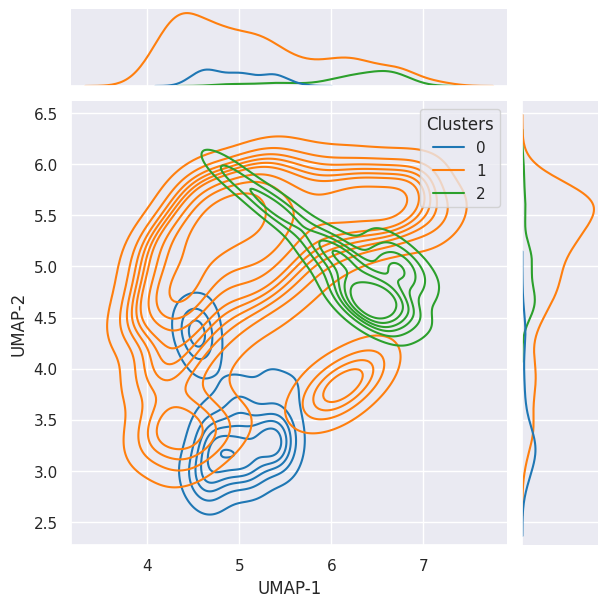

In [15]:
g = sns.jointplot(
    x=embedding[clustered, 0], 
    y=embedding[clustered, 2], 
    hue=labels[clustered], 
    kind="kde", palette='tab10' )

g.set_axis_labels("UMAP-1", "UMAP-2")

legend = g.ax_joint.get_legend()
if legend:
    legend.set_title("Clusters")

plt.show()

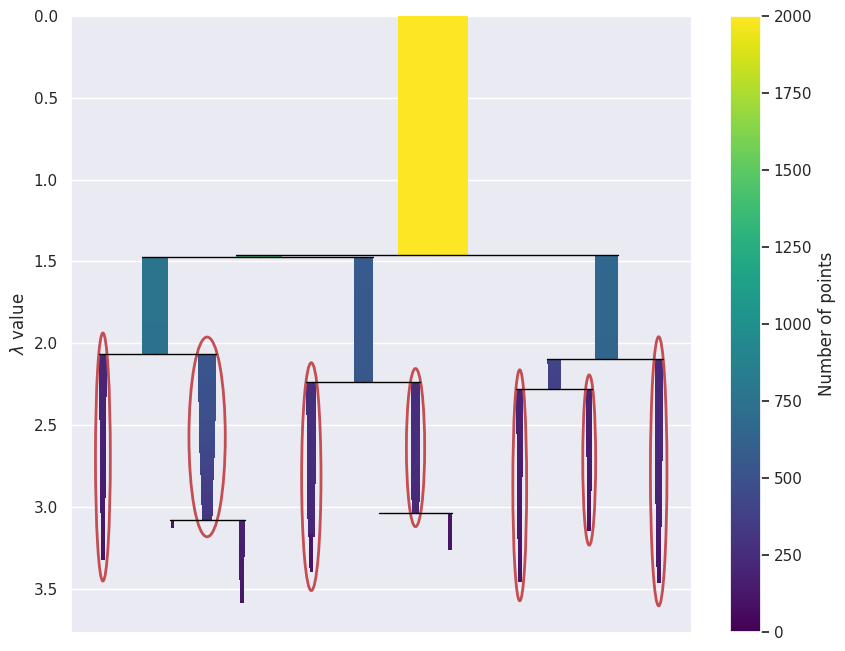

In [72]:
clf.hdbscan_.condensed_tree_.plot(
    select_clusters=True,
    selection_palette=sns.color_palette("deep", np.unique(clustered).shape[0]),
)

plt.show()

In [ ]:
coverage = np.sum(clustered) / embedding.shape[0]

print(f"Coverage {coverage}")
print(f"DBCV score {clf.hdbscan_.relative_validity_}")

Coverage 0.951
DBCV score 0.007384599854476561


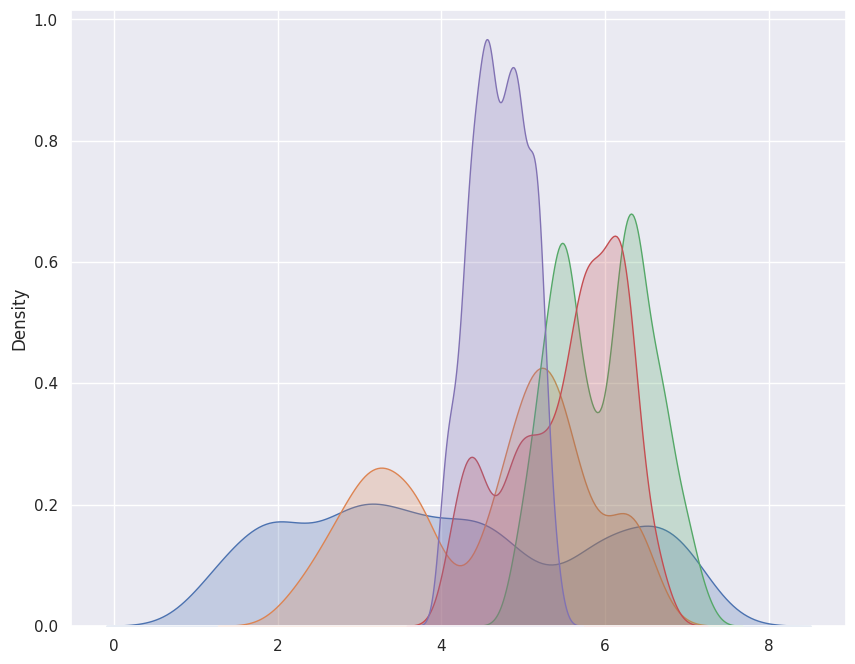

In [62]:
for i in range(len(clf.mapper_.embedding_[0])):
    sns.kdeplot(clf.mapper_.embedding_[:, i], fill=True)

plt.show()

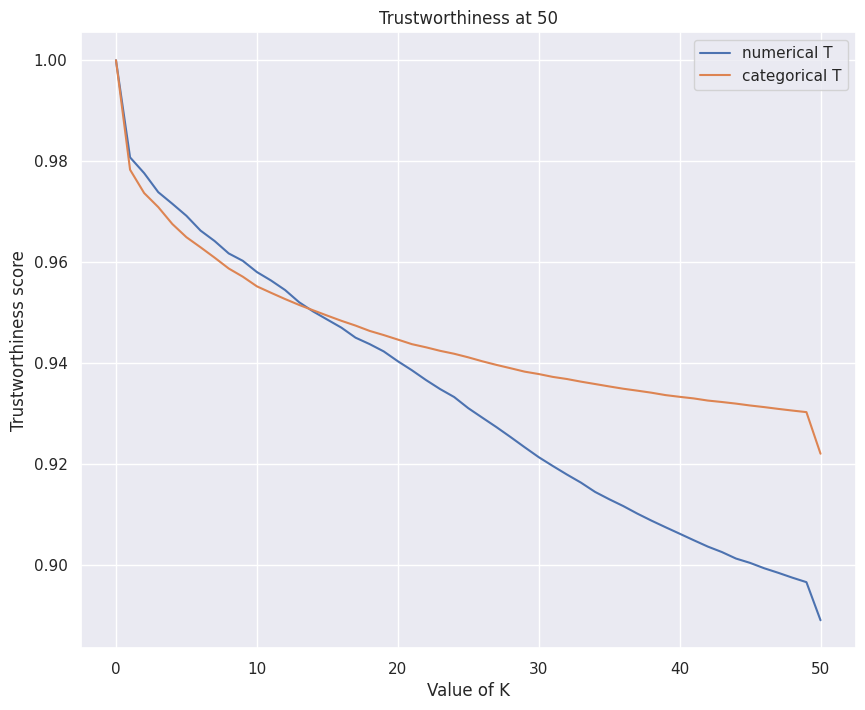

In [63]:
K = 50

# supress numba deprecation warnings from UMAP
filterwarnings("ignore")

numerical_trustworthiness = validation.trustworthiness_vector(
    source=clf.numerical_umap_._raw_data, embedding=clf.numerical_umap_.embedding_, max_k=K
)

categorical_trustworthiness = validation.trustworthiness_vector(
    source=clf.categorical_umap_._raw_data, embedding=clf.categorical_umap_.embedding_, max_k=K
)

filterwarnings("default")


plt.plot(numerical_trustworthiness)
plt.plot(categorical_trustworthiness)
plt.ylabel("Trustworthiness score")
plt.xlabel("Value of K")
plt.title(f"Trustworthiness at {K}")

plt.legend(["numerical T", "categorical T"], loc="upper right")

plt.show()

#### 클러스터링 결과 저장

In [ ]:
SAVE_PATH = './results'

df['segment'] = clf.evaluate()

# CSV로 저장
df.to_csv(os.path.join(SAVE_PATH, "clustered_data.csv"), index=False)